## Pairs Trading Strategies Using Python

When it comes to making money in the stock market, there are a myriad of different ways to make money. And it seems that in the finance community, everywhere you go, people are telling you that you should learn Python. After all, Python is a popular programming language which can be used in all types of fields, including data science. There are a large number of packages that can help you meet your goals, and many companies use Python for development of data-centric applications and scientific computation, which is associated with the financial world.

Most of all Python can help us utilize many different trading strategies that (without it) would by very difficult to analyze by hand or with spreadsheets. One of the trading strategies we will talk about is referred to as **Pairs Trading.**

## Pairs Trading

Pairs trading is a form of *mean-reversion* that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The stratey is based on mathematical analysis.

The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In order to understand pairs trading, we need to understand three mathematical concepts: **Stationarity, Integration, and Cointegration**.

**Note:** This will assume everyone knows the basics of hypothesis testing.

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Stationarity/Non-Stationarity

Stationarity is the most commonly untestedassumption in time series analysis. We generally assume that data is stationary when the parameters of the data generating process do not change over time. Else consider two series: A and B. Series A will generate a stationary time series with fixed parameters, while B will change over time.

We will create a function that creates a z-score for probability density function. The probability density for a Gaussian distribution is:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$


$\mu$ is the mean and $\sigma$ is the standard deviation. The square of the standard deviation, $\sigma^{2}$, is the variance. The empircal rule dictates that 66% of the data should be somewhere between $x+\sigma$ and $x-\sigma$,which implies that the function `numpy.random.normal` is more likely to return samples lying close to the mean, rather than those far away.

In [2]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

From there, we can create two plots that exhibit a stationary and non-stationary time series.

Text(0.5,1,'Non-Stationary')

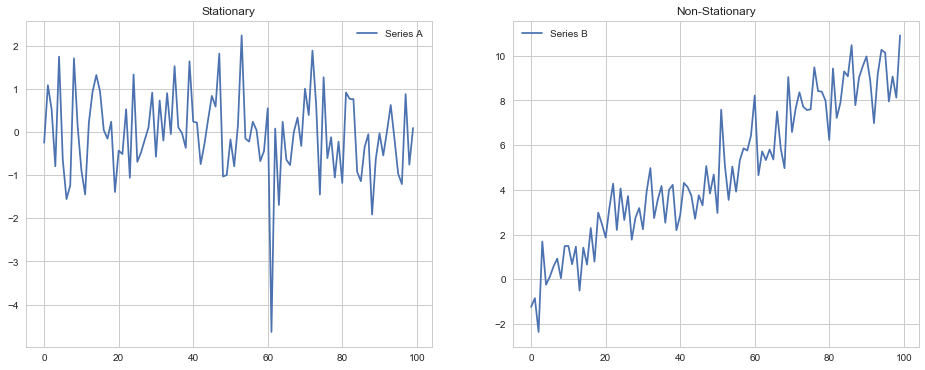

In [3]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

### Why Stationarity is Important

Many statistical test require that the data being tested are stationary. Using certain statistics on a non-stationary data set may lead to garbage results. As an example, let's take an average through our non-stationary $B$.

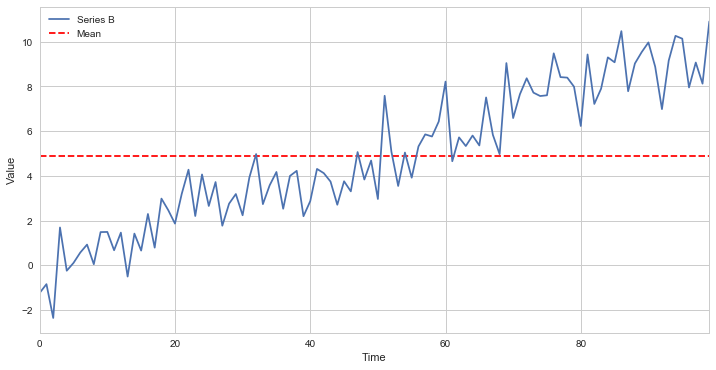

In [4]:
mean = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 99])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

The computed mean will show that the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specific time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can distort the analysis, much more subtle problems can arise in practice.

#### Augmented Dickey Fuller

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal of $\scr{z}_{t},\ \phi (\scr{z})=\ (1-\phi \scr{z}) \ = 0$, has a root equal to unity. 

$y_{t}$ is trend stationary under the null hypothesis. If $y_{t}$is then first differenced, it becomes:

$$
\begin{aligned}
\Delta y_{t} & = \delta\ + \Delta\scr{z}_{t} \\
\Delta \scr_{z} & = \phi\Delta\scr{z}_{t-1}\ +\ \varepsilon_{t}\ -\ \varepsilon_{t-1} \\
\end{aligned}
.$$

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$

$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or 

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

In [5]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [6]:
stationarity_test(A)
stationarity_test(B)

p-value = 9.46955288209042e-09 The series A is likely stationary.
p-value = 0.783559641489532 The series B is likely non-stationary.


As we can see, based on the test statistic (which correspnds with a specific p-value) for time series A, we can fail to reject the null hypothesis. As such, Series A is likely to be  stationary. On the other hand, Series B is rejected by the hypothesis test, so this time series is likely to be non-stationary.

### Cointegration

The correlations between financial quantities are notoriously unstable. Nevertheless, correlations are regularly used in almost all multivariate financial problems. An alternative statistical measure to correlation is cointegration. This is probably a more robust measure of linkage between two financial quantities, but as yet there is little derviaties theory based on this concept.

Two stocks may be perfectly correlated over short timescales, yet diverge in the long run, with one growing and the other decaying. Conversely, two stocks may follow each other, never being more than a certain distance apart, but with any correlation, positive negaative or varying. If we are delta hedging, then maybe the short timescale orrelation matters, but not if we are holding stocks for a long time in an unhedged portfolio.

We've constructed an example of two cointegrated series. We'll plot the difference between the two now so we can see how this looks.

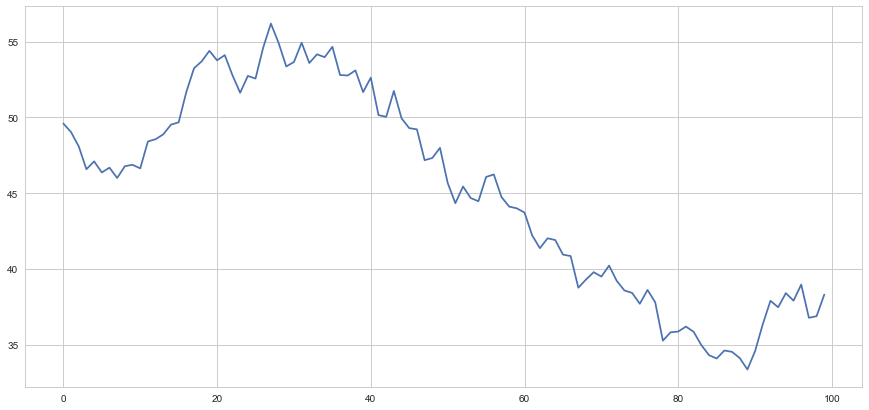

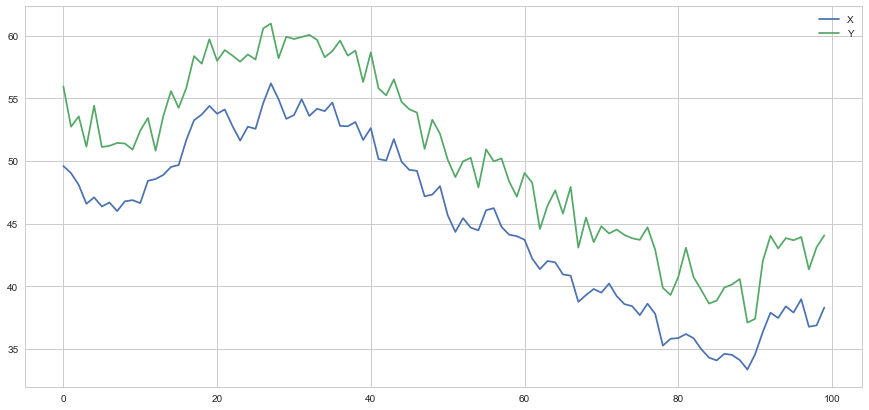

In [7]:
# Generate daily returns

Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))

plt.show()

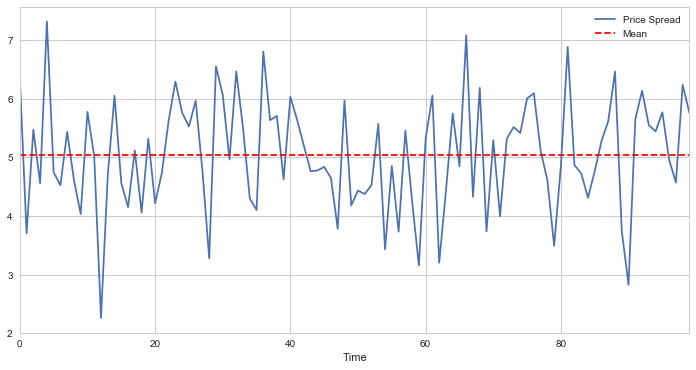

In [8]:

plt.figure(figsize=(12,6))
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

#### Testing for Cointegration

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If we find that the time series as a unit root, then we move on to the cointegration process. There are three main methods for testing for cointegration: Johansen, Engle-Granger, and Phillips-Ouliaris. We will primarily use the Engle-Granger test.

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$

Now that you understand what it means for two time series to be cointegrated, we can test for it and measure it using python:

In [9]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

0.6954004892372526


#### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similiar, are anything but similiar. To demonstrate this, we can look at examples of two time series that are correlated, but not cointegrated.

A simple example is two series that just diverge.

(0, 99)

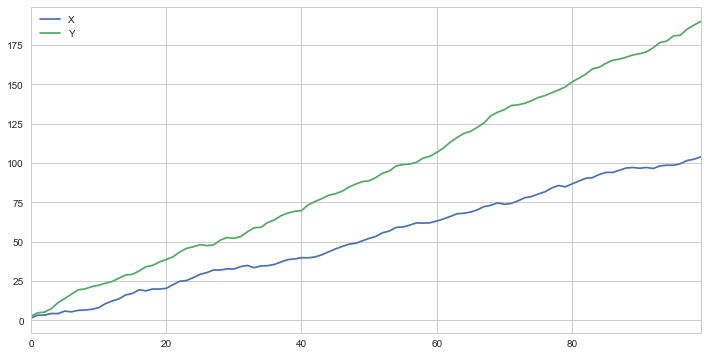

In [10]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99)


Next, we can print the correlation coefficient, $r$, and the cointegration test 

In [11]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.9973711657681065
Cointegration test p-value: 0.2199346728835888


As we can see, there is a very strong (nearly perfect) correlation between series X and Y. However, our p-value for the cointegration test yields a result of 0.7092, which means there is no cointegration between time series X and Y.

Another example of this case is a normally distributed series and a sqaure wave.

Correlation: -0.01013186360545287
Cointegration test p-value: 9.087136314506316e-10


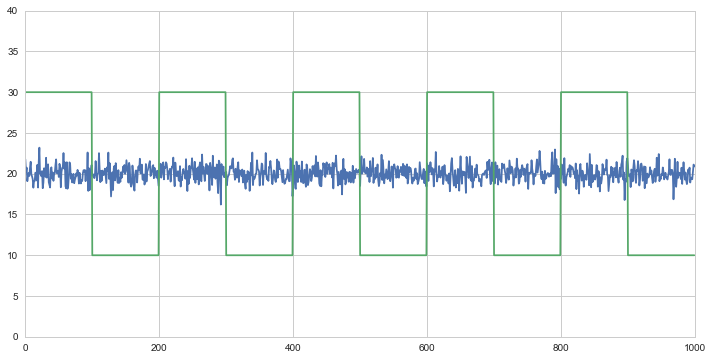

In [12]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

Although the correlation is incredibly low, the p-value shows that these time series are cointegrated.

In [13]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import fix_yahoo_finance as yf
yf.pdr_override()

### Data Science in Trading

Before we begin, I’ll first define a function that makes it easy to find cointegrated security pairs using the concepts we’ve already covered.

In [14]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

We are looking through a set of tech companies to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security from the year 2013 - 2018..

As mentioned before, we have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

In [15]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['AAPL', 'ADBE', 'SYMC', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 downloaded


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,QCOM,SPY,SYMC
Date,,,,,,,,,,,
2017-12-22,175.009995,175.000000,10.54,37.759998,21.26,152.500000,28.860001,85.510002,64.730003,267.510010,28.320000
2017-12-26,170.570007,174.440002,10.46,37.939999,21.23,152.830002,28.860001,85.400002,64.300003,267.190002,28.230000
2017-12-27,170.600006,175.360001,10.53,37.610001,21.27,153.130005,28.879999,85.709999,64.540001,267.320007,28.450001
2017-12-28,171.080002,175.550003,10.55,37.919998,21.15,154.039993,28.870001,85.720001,64.379997,267.869995,28.480000
2017-12-29,169.229996,175.240005,10.28,37.740002,21.01,153.419998,28.500000,85.540001,64.019997,266.859985,28.059999


[('ADBE', 'EBAY'), ('ADBE', 'MSFT')]


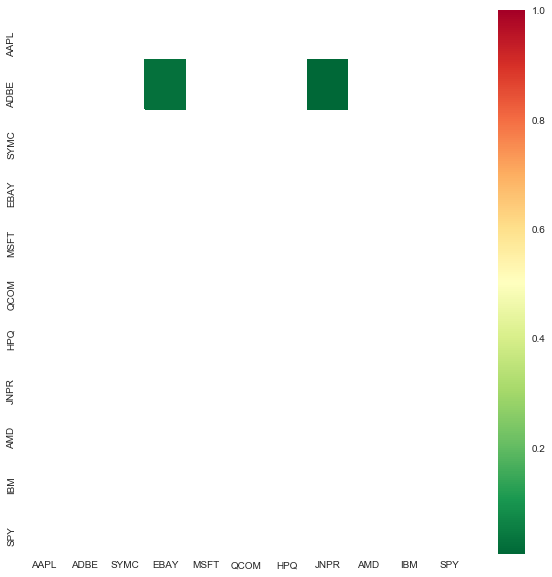

In [16]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

Our algorithm listed two pairs that are cointegrated: AAPL/EBAY, and ABDE/MSFT. We can analyze their price patterns to make sure there is nothing weird going on.

In [17]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.006279979946672622

As we can see, the p-value is less than 0.05, which means ADBE and EBAY are indeed cointegrated pairs.

#### Calculating the Spread

Now we can plot the spread of the two time series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities, as mentioned with the Engle-Granger method before.

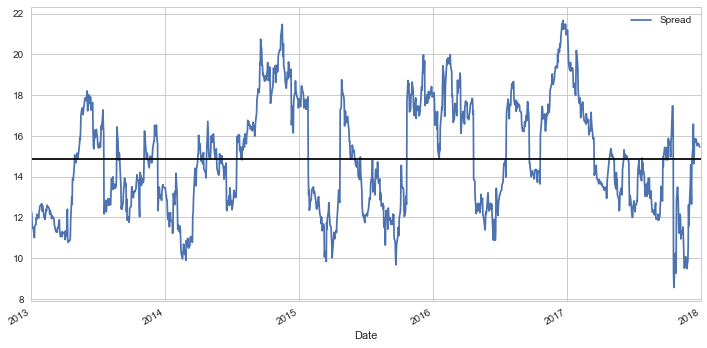

In [18]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

Alternatively, we can examine the ration between the two time series

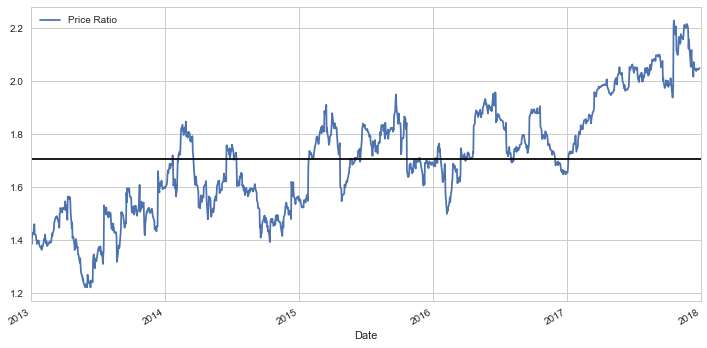

In [19]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair ADBE/SYMC tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

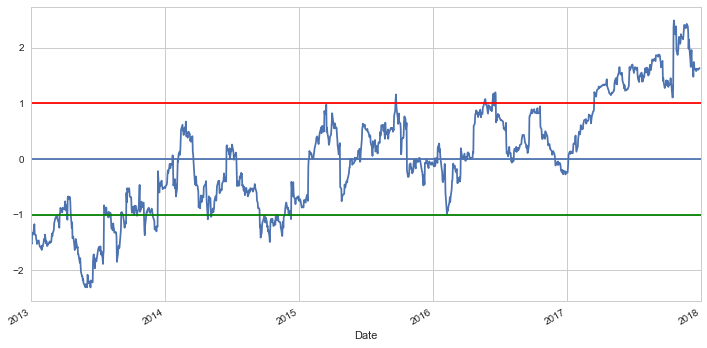

In [20]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

### Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock? 

#### Setup rules

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

#### Train Test Split

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

In [21]:
ratios = df['ADBE'] / df['MSFT'] 
print(len(ratios) * .70 ) 

881.3


In [22]:
train = ratios[:881]
test = ratios[881:]

#### Feature Engineering

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

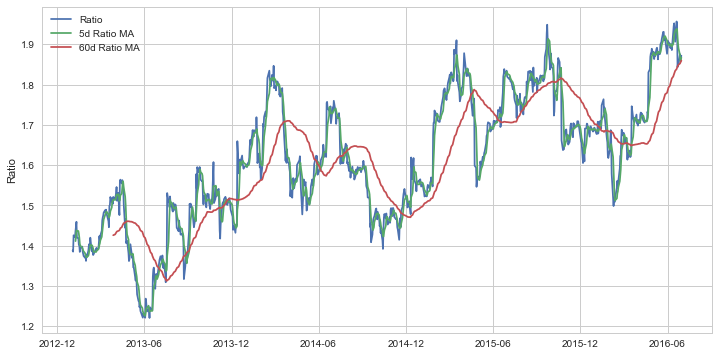

In [23]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

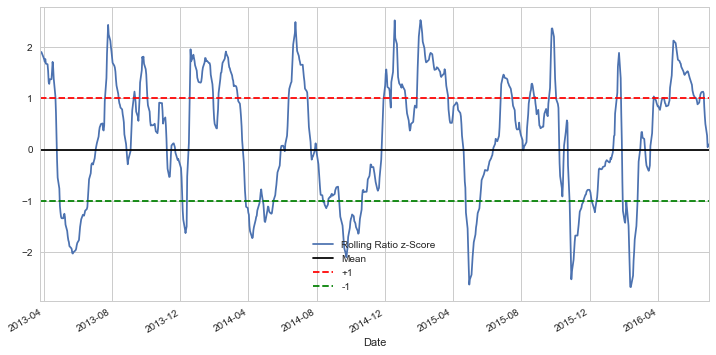

In [24]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

#### Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

#### Training Optimizing

We can use our model on actual data

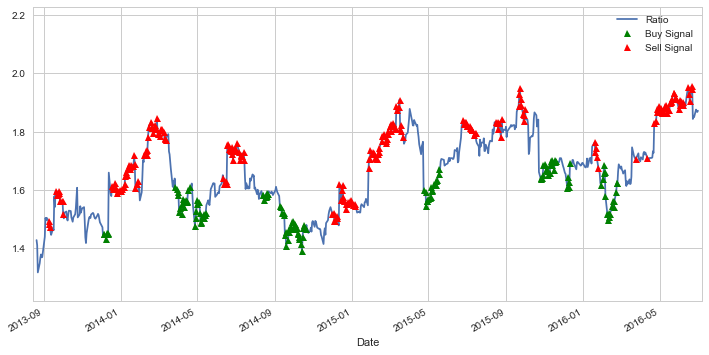

In [25]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

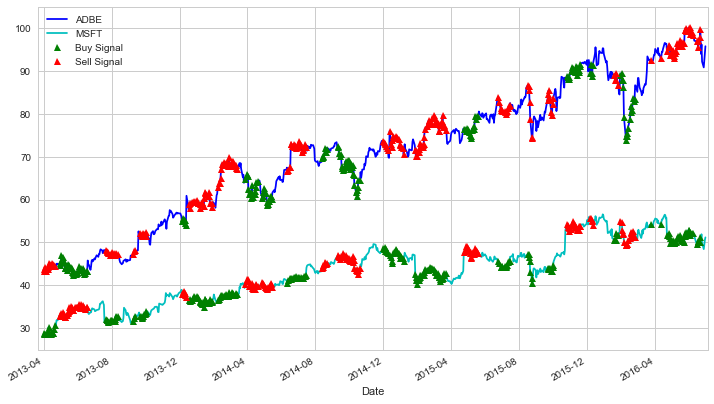

In [26]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:881]
S2 = df['MSFT'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

Now we can clearly see when we should buy or sell on the respective stocks.

Now, how much can we expect to make of this strategy?

In [27]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [28]:
trade(df['ADBE'].iloc[881:], df['MSFT'].iloc[881:], 60, 5)

451.856070526494

Not a bad profit for a strategy that is made from stratch.

### Areas of Improvement and Further Steps

This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.

#### 1. Using more securities and more varied time ranges

For the pairs trading strategy cointegration test, I only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry. I only use the time range of only 5 years, which may not be representative of stock market volatility.

#### 2. Dealing with overfitting

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

#### 3. Adjusting the trading signals

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

#### 4. More advanced methods

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.